# Udacity Self-Driving Car Nanodegree

## Advanced Lane Finding Project

#### The goal / steps of this project are following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc. to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ('binary-eye view').
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original images.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import the python modules.

In [1]:
import numpy as np 
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive ,fixed
from moviepy.editor import VideoFileClip 
from IPython.display import HTML

%matplotlib inline

print ('imported successfully!')

imported successfully!


### Compute the camera calibration with the chessboard images

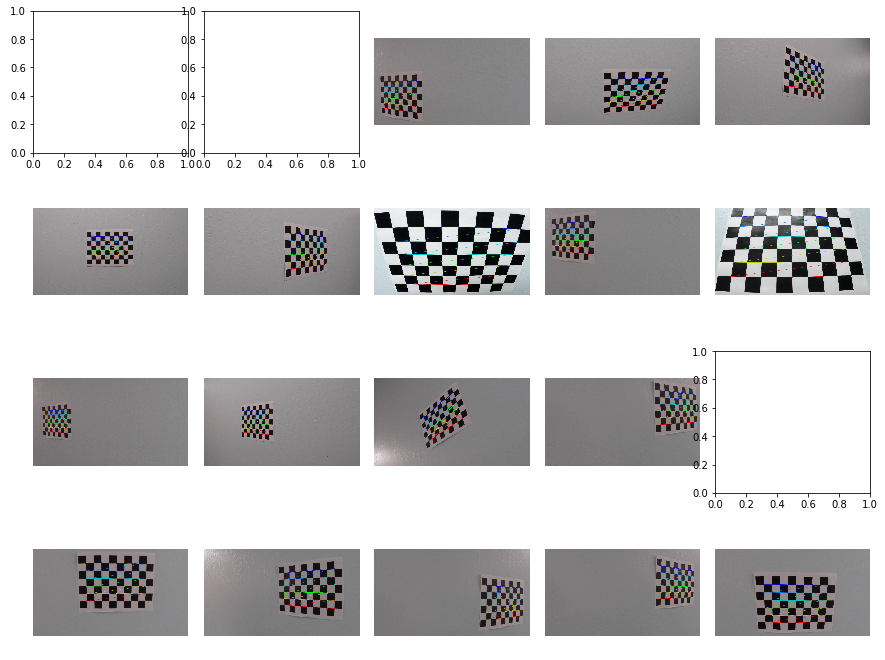

In [2]:
# Prepare object points, like (0,0,0),(1,0,0), all the third elements are zeros
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store objects points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare the figure where the images are going to be drawn here
fig,axes = plt.subplots(4,5,figsize=(15,12))
fig.subplots_adjust(hspace=0.2,wspace=.1)
axes = axes.ravel()

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# step through the list and search for chessboard corners
for i, image in enumerate(images):
    
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    #If the corners are found then plot the corners in the corresponding images
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the corners in the images
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        axes[i].axis('off')
        axes[i].imshow(img)
  

As we can see from above results, there are totally three images are not showned due to the specific number of corners is not found in them.

Done! Luke


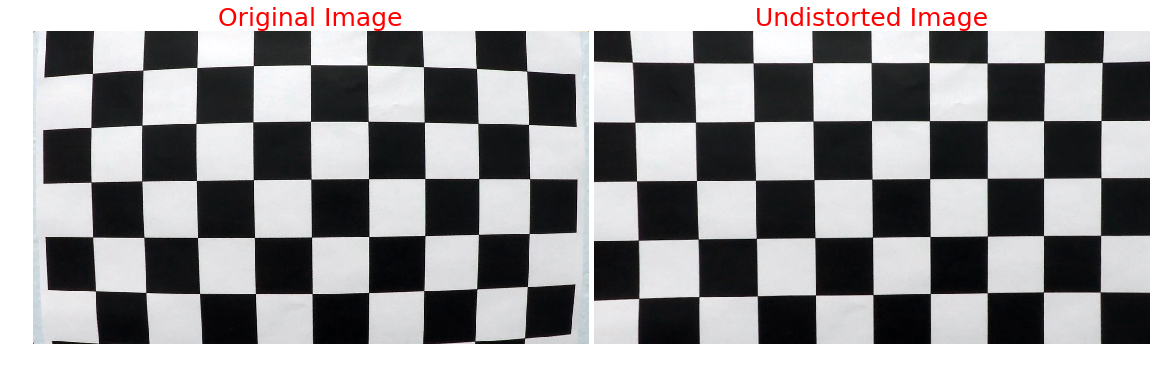

In [3]:
# To calibrate the camera, abtainning the calibration matrix and distortion coefficients
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1],img.shape[0])

# Get the internal parameters for the camera using the cv2.calibrateCamera function
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
dst = cv2.undistort(img,mtx,dist,None,mtx)

# Using the pickle tool to store the mtx and dist parameters for future use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle,open('calibration.p','wb'))

# Create the figure to show the original and undistorted images for comparison
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
f.subplots_adjust(hspace=0.2,wspace=0.01)
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image',fontsize=25,color='red')
ax2.imshow(dst)
ax2.axis('off')
ax2.set_title('Undistorted Image',fontsize=25,color='red')

print ('Done! Luke')

From the above, we can explicitly see that the undistorted images has already correctly modified.

### Example Image

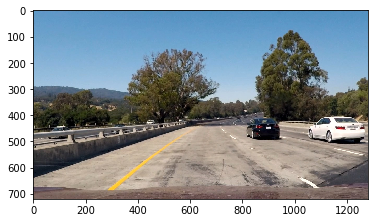

In [4]:
# Choose an image from which to build and demonstrate each step of the piptline
ExampleImg = cv2.imread('./test_images/test1.jpg')
# Since the matplotlib show the image with RGB, conversely, cv2 is using the BGR color space
ExampleImg = cv2.cvtColor(ExampleImg,cv2.COLOR_BGR2RGB)
plt.imshow(ExampleImg)


Distorted function difined.
Undistorted funtion for the road image!


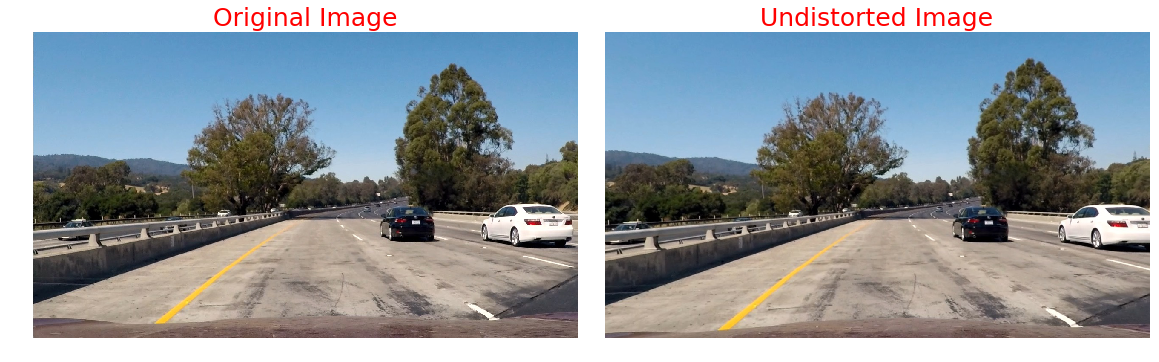

In [5]:
# Define the undistort function for the pipeline
def undistort(img):
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

print ('Distorted function difined.')

ExampleImg_undist = undistort(ExampleImg)

# Show the two images for comparison
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,15))
f.subplots_adjust(hspace=0.2,wspace=0.05)
ax1.imshow(ExampleImg)
ax1.axis('off')
ax1.set_title('Original Image',fontsize=25,color='red')
ax2.imshow(ExampleImg_undist)
ax2.axis('off')
ax2.set_title('Undistorted Image',fontsize=25,color='red')

print ('Undistorted funtion for the road image!')

The undistorted function effect can be seen from the shape modification of the car hood.

## Perspective Transform
The assumpation is that the road is almost the flat and the camera is fixed.

In [6]:
# Define the pespective transform function
def unwarp(img,src,dst):
    h,w = img.shape[:2]
    # The dst are four destination points, the src are four source points 
    M = cv2.getPerspectiveTransform(src,dst)
    
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # Apply the transformation matrix on the original image to get the warped one
    warped = cv2.warpPerspective(img,M,(w,h),flags=cv2.INTER_LINEAR)
    
    return warped,M,Minv

print ('The Pespective transform function defined!')
    

The Pespective transform function defined!


Unwarped function comparison.


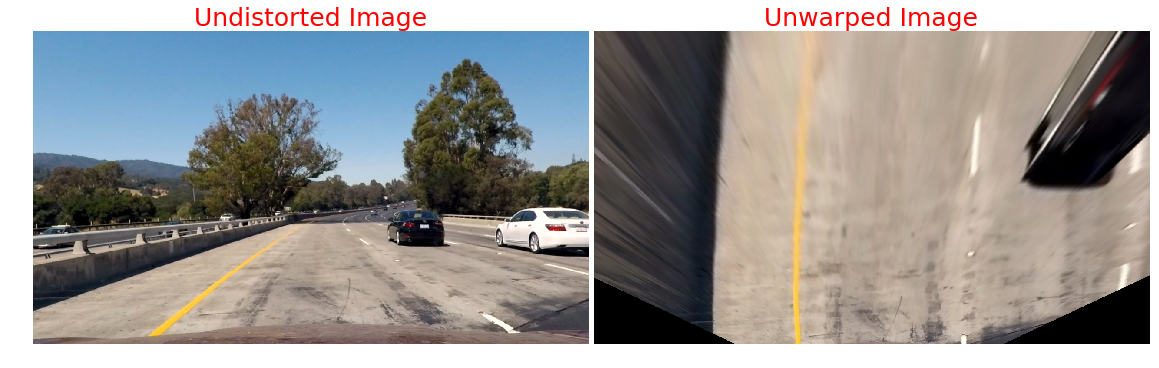

In [7]:
# Apply the perspective transform function on the example images
h,w = ExampleImg_undist.shape[:2]

# Define source and destination points for transform
src = np.float32([(575,464),(707,464),(258,682),(1049,682)])

dst = np.float32([(450,0),(w-450,0),(450,h),(w-450,h)])

ExampleImg_unwarp,M,Minv = unwarp(ExampleImg_undist,src,dst)

# Visualize the unwarp
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
f.subplots_adjust(hspace=0.2,wspace=0.01)
ax1.axis('off')
ax1.imshow(ExampleImg_undist)
ax1.set_title('Undistorted Image',fontsize=25,color='red')
ax2.axis('off')
ax2.imshow(ExampleImg_unwarp)
ax2.set_title('Unwarped Image',fontsize=25,color='red')


print ('Unwarped function comparison.')



## Get the binary mask output where we can clearly and easily get the Lane lines
* The gradient method including the gradient threshold, gradient magnitute and gradient direction.
* The color space method, here we just talk about the RGB, HLS and LAB color space which are mentioned on the course.

The gradient abs,gradient mg, gradient direc functions defined.


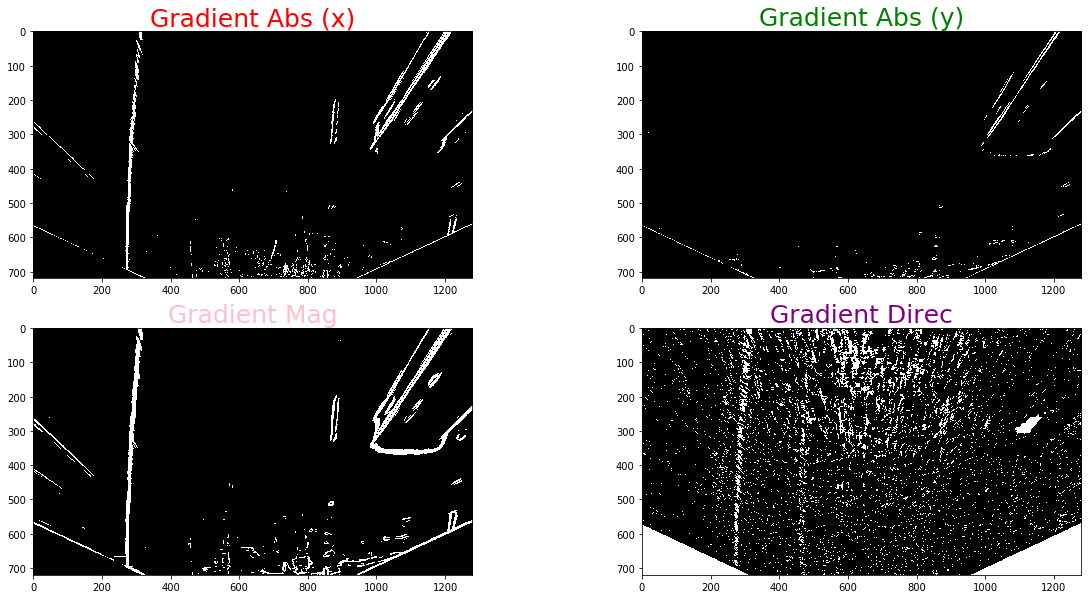

In [8]:
# Gradient method, define the gradient threshold, gradient magnitute and gradient direction function for future usage.

def gradient_abs(img,orient='x',threshold=(25,255)):
    # convert the img into the gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # Take the derivetive in x or y axis
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    # Get the absolute value for the derivative of gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8bit (0-255) range
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    # Create the mask of 1's where the scaled gradient magnitude is >threshod[0] and < threshold[1]
    binary = np.zeros_like(scaled_sobel)
    binary [(scaled_sobel >= threshold[0])&(scaled_sobel<threshold[1])] = 1
    
    return binary



def gradient_magnitude(img,sobel_kernel=15,threshold=(25,255)):
    # convert into grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Get the gradients for x and y axes
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Calculate the magnitude
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # Scale into (0,255)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Create the binary mask 
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel>=threshold[0])&(scaled_sobel<=threshold[1])] = 1
    
    return binary

def gradient_direc(img,sobel_kernel=9,threshold=(0,0.09)):
    # convert into gray
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Calculate the gradient of x and y axes
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # Get the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    # Get the direction of the gradient
    sobel_direc = np.arctan2(sobely_abs,sobelx_abs)
    # Create the binary
    binary = np.zeros_like(sobel_direc)
    binary[(sobel_direc>=threshold[0])&(sobel_direc<=threshold[1])] = 1
    
    return binary

print ('The gradient abs,gradient mg, gradient direc functions defined.')

binaryx_abs = gradient_abs(ExampleImg_unwarp)
binaryy_abs = gradient_abs(ExampleImg_unwarp,orient='y')
binary_mag = gradient_magnitude(ExampleImg_unwarp)
binary_direc = gradient_direc(ExampleImg_unwarp)

fig, axes = plt.subplots(2,2,figsize=(20,10))
axes = axes.ravel()

axes[0].imshow(binaryx_abs,cmap='gray')
axes[0].set_title('Gradient Abs (x)',fontsize=25,color='red')

axes[1].imshow(binaryy_abs,cmap='gray')
axes[1].set_title('Gradient Abs (y)',fontsize=25,color='Green')

axes[2].imshow(binary_mag,cmap='gray')
axes[2].set_title('Gradient Mag',fontsize=25,color='pink')

axes[3].imshow(binary_direc,cmap='gray')
axes[3].set_title('Gradient Direc',fontsize=25,color='purple')

From the above gradient threshold results, We can deduce that in order to clearly map out the lane lines from the unwarped images, we better choose the gradient_abs X  and gradient_mag. However, the gradient has a lot of other information mapping out which is irrelevant to our request.

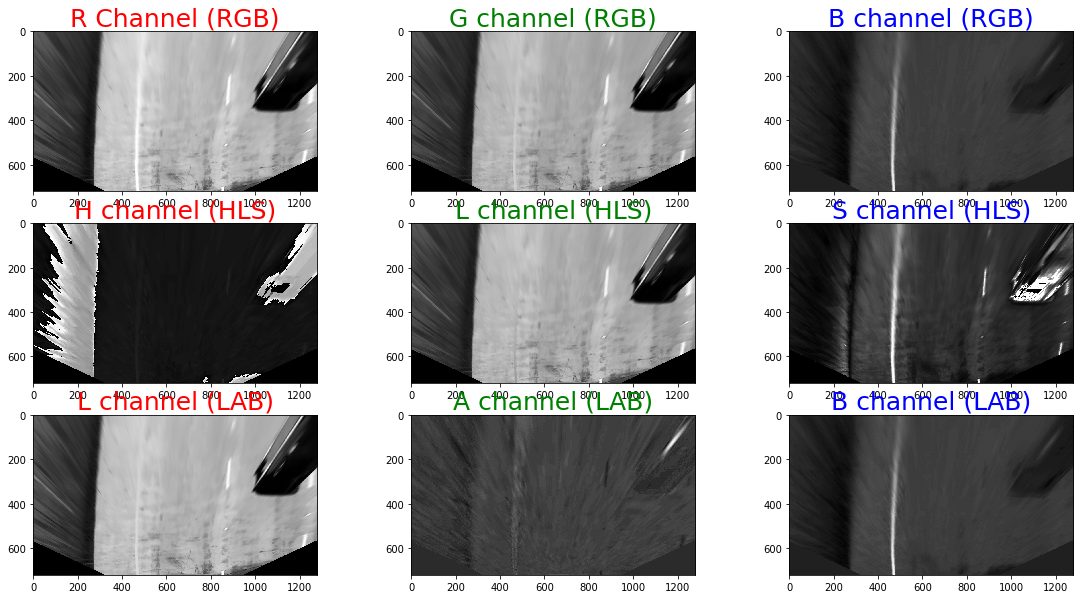

In [9]:
# Find the suitable color spaces for selection of the lane lines 
# Visualize the multiple color space channels

# In RGB color space
ExampleImg_unwarp_R = ExampleImg_unwarp[:,:,0]
ExampleImg_unwarp_G = ExampleImg_unwarp[:,:,1]
ExampleImg_unwarp_B = ExampleImg_unwarp[:,:,2]

# Convert into the HLS color space
ExampleImg_unwarp_HLS = cv2.cvtColor(ExampleImg_unwarp,cv2.COLOR_RGB2HLS)
ExampleImg_unwarp_H= ExampleImg_unwarp_HLS[:,:,0]
ExampleImg_unwarp_L = ExampleImg_unwarp_HLS[:,:,1]
ExampleImg_unwarp_S = ExampleImg_unwarp_HLS[:,:,2]

# Convert into the LAB color space
ExampleImg_unwarp_LAB = cv2.cvtColor(ExampleImg_unwarp,cv2.COLOR_RGB2Lab)
ExampleImg_unwarp_L2 = ExampleImg_unwarp_LAB[:,:,0]
ExampleImg_unwarp_A = ExampleImg_unwarp_LAB[:,:,1]
ExampleImg_unwarp_B = ExampleImg_unwarp_LAB[:,:,2]

fig,axs = plt.subplots(3,3,figsize=(20,10))
fig.subplots_adjust(hspace=0.2,wspace=0.05)
axs = axs.ravel()

axs[0].imshow(ExampleImg_unwarp_R,cmap='gray')
#axs[0].axis('off')
axs[0].set_title('R Channel (RGB)',fontsize=25,color='red')

axs[1].imshow(ExampleImg_unwarp_G,cmap='gray')
#axs[1].axis('off')
axs[1].set_title('G channel (RGB)',fontsize=25,color="green")

axs[2].imshow(ExampleImg_unwarp_B,cmap='gray')
#axs[2].axis('off')
axs[2].set_title('B channel (RGB)',fontsize=25,color="blue")

axs[3].imshow(ExampleImg_unwarp_H,cmap='gray')
#axs[3].axis('off')
axs[3].set_title('H channel (HLS)',fontsize=25,color='red')

axs[4].imshow(ExampleImg_unwarp_L,cmap='gray')
axs[4].set_title('L channel (HLS)',fontsize=25,color='green')

axs[5].imshow(ExampleImg_unwarp_S,cmap='gray')
axs[5].set_title('S channel (HLS)',fontsize=25,color='blue')

axs[6].imshow(ExampleImg_unwarp_L2,cmap='gray')
axs[6].set_title('L channel (LAB)',fontsize=25,color='red')

axs[7].imshow(ExampleImg_unwarp_A,cmap='gray')
axs[7].set_title('A channel (LAB)',fontsize=25,color='green')

axs[8].imshow(ExampleImg_unwarp_B,cmap='gray')
axs[8].set_title('B channel (LAB)',fontsize=25,color='blue')


From the above results, we can see that the R channel (RGB), and B channel(RGB), L channel(HLS),B channel(LAB) will be the better choices. However,considering the lightness influence for the RGB, here optimally we are going to use L channel (HLS) and B channel (LAB). 

<function __main__.Draw_dynamically>

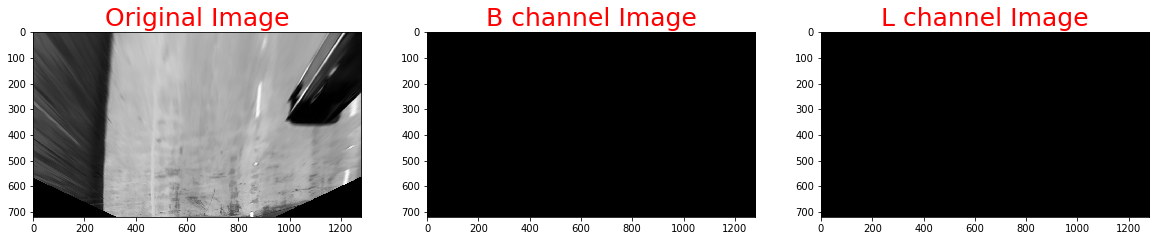

In [10]:
# Define the threshold function for the L channel in HLS color space
def lab_b(img,min_threshold=199,max_threshold=255):
    # Change the RGB color space into LAB color space
    img_lab = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    
    # Get the B channel which is sensitive to the white color lane line
    img_b = img_lab[:,:,2]
    
    if np.max(img_b) > 175:
        img_b = img_b*(255/np.max(img_b))
    
    # Scaled the value into range of (0,255)
    #img_b_scaled= img_b * (255 / np.max(img_b))
    
    # Get the binary mask for the L channel
    binary = np.zeros_like(img_b)
    binary[(img_b > min_threshold) & (img_b<= max_threshold)] = 1
    
    return binary
def hls_l(img,min_threshold=220,max_threshold=255):
    # Change the RGB color space into HLS coloe space
    img_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # Get the L channel which is sensitive to the yellow lane line
    img_l = img_hls[:,:,1]
   # print(img_l)
   # print(ExampleImg_unwarp_L)
    # Scaled the value into range of (0,255)
    #img_l = np.uint8(255 * img_l / np.max(img_l))
    img_l= img_l*(255/np.max(img_l))
    # Get the binary mask of the image
   
    binary = np.zeros_like(img_l)
    binary[(img_l > min_threshold) & (img_l<= max_threshold) ] = 1

    return binary



def Draw_dynamically(min_thresholdB,max_thresholdB,min_thresholdL,max_thresholdL):
    gray = cv2.cvtColor(ExampleImg_unwarp,cv2.COLOR_RGB2GRAY)
    binary_b = lab_b(ExampleImg_unwarp,min_thresholdB,max_thresholdB)
    binary_l = hls_l(ExampleImg_unwarp,min_thresholdL,max_thresholdL)
    # Draw the images into a figure
    fig,axs = plt.subplots(1,3,figsize=(20,10))
    fig.subplots_adjust(hspace=0.05,wspace=0.2)
    axs = axs.ravel()
    
    axs[0].imshow(gray,cmap='gray')
    axs[0].set_title('Original Image',fontsize=25,color='red')
    
    axs[1].imshow(binary_b,cmap='gray')
    axs[1].set_title('B channel Image',fontsize=25,color='red')
    
    axs[2].imshow(binary_l,cmap='gray')
    axs[2].set_title('L channel Image',fontsize=25,color='red')
    
interact(Draw_dynamically,min_thresholdB=(0,255),max_thresholdB=(0,255),min_thresholdL=(0,255),max_thresholdL=(0,255))


In [11]:
# Define the compelete image processing pipeline, reading new images and returns ubinary image with lane lines idetified 
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # persperctive Transfrom
    img_unwarp,M,Minv = unwarp(img_undistort,src,dst)
    
    # Lab B-channel Threshold
    img_BThresh = lab_b(img_unwarp)
    # HLS l-channel threshold
    img_LThresh = hls_l(img_unwarp)
    
    # Combine HLS and LAB B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    
    return combined, Minv

print ("Done pipeline")

Done pipeline


...


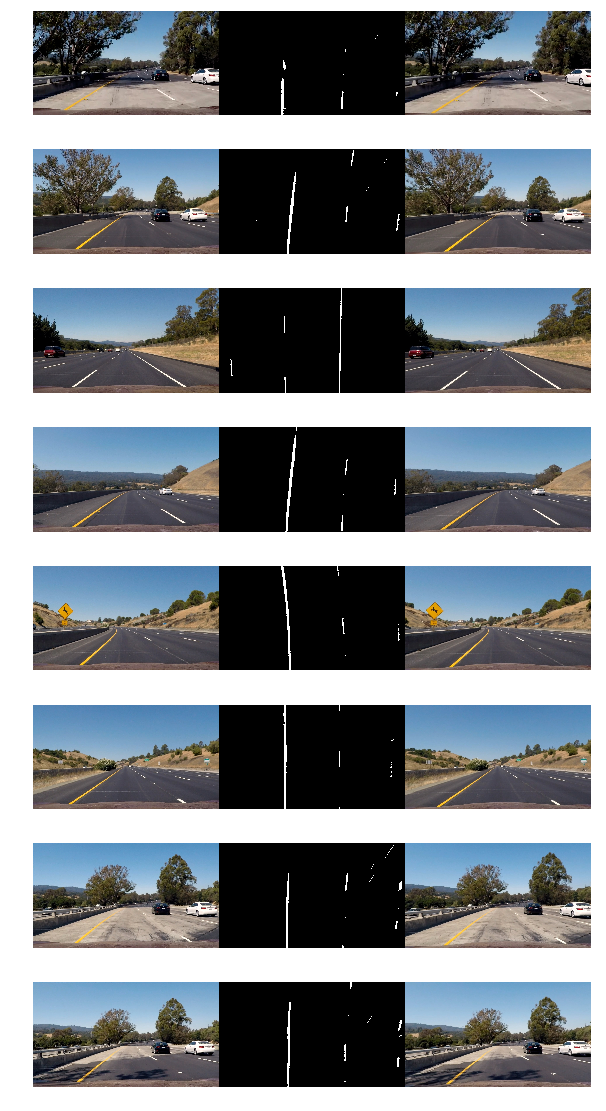

In [13]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_distort = undistort(img)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_distort)
    axs[i].axis('off')
    i += 1


print('...')

### Sliding Window Polyfit For the Lane lines.

In [14]:
# Define method to fit polynomial to binary image with lanes extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a look of the histogram of the bottom half image
    histogram = np.sum(img[img.shape[0]//2:,:],axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # There will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    
    # Previously the left/right base was the max of the left/right half of the histogram
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:midpoint+quarter_point]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y position of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set the minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists ro receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle_data for visualization
    rectangle_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (both from left and right)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low,win_y_high,win_xleft_low,win_xleft_high,win_xright_low,win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If yu found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    left_fit, right_fit = (None,None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty,rightx,2)
        
    visualization_data = (rectangle_data,histogram)
        
    return left_fit,right_fit,left_lane_inds,right_lane_inds,visualization_data

print ('Polynomial Fitting Done!')

Polynomial Fitting Done!


#### Testing the images through the above pipeline for polynomial fitting of the lane lines

Done!


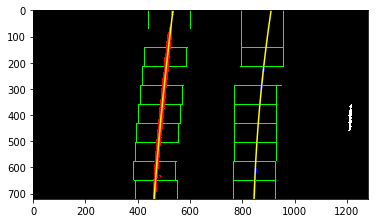

In [15]:
# Visualize the result on example image
exampleImg = cv2.imread('./test_images/test3.jpg')
exampleImg = cv2.cvtColor(exampleImg,cv2.COLOR_BGR2RGB)
exampleImg_bin,Minv = pipeline(exampleImg)

left_fit,right_fit,left_lane_inds,right_lane_inds,visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0] * h ** 2 + left_fit[1] * h + left_fit[2]
right_fit_x_int = right_fit[0] * h ** 2 + right_fit[1] * h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin,exampleImg_bin,exampleImg_bin)) * 255)

# Generate x and y values for plotting
ploty = np.linspace(0,exampleImg_bin.shape[0]-1,exampleImg_bin.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

for rect in rectangles:
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0),2)
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0),2)
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]
plt.imshow(out_img)
plt.plot(left_fitx,ploty,color='yellow')
plt.plot(right_fitx,ploty,color='yellow')
plt.xlim(0,1280)
plt.ylim(720,0)

print ('Done!')

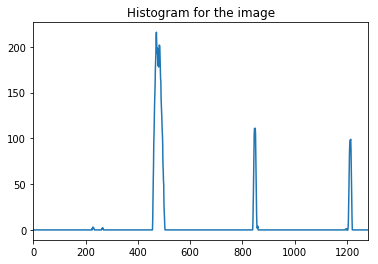

In [16]:
# Print histogram from sliding window plotfit for example image
plt.plot(histogram)
plt.xlim(0,1280)
plt.title('Histogram for the image')

#### Polyfit Using the previous frame

In [17]:
# Define method to fit polynomial to binary image based upon a previous fit
# This assumes that the fits will not change significantly from one video frame to the next

def polyfit_using_prev_fit(binary_warped,left_fit_prev,right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0] * (nonzeroy ** 2) + left_fit_prev[1] * nonzeroy + left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0] * (nonzeroy ** 2 ) + left_fit_prev[1] * nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new,right_fit_new = (None,None)
    
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty,rightx,2)
        
    return left_fit_new,right_fit_new,left_lane_inds,right_lane_inds

print('Done!')
    
                       

Done!


Done!


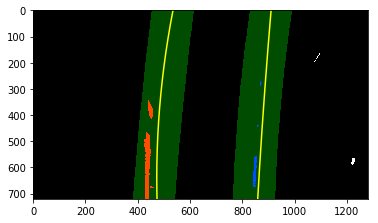

In [18]:
# Visualize theresult on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2,cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)
margin = 80


left_fit2,right_fit2,left_lane_inds2,right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin,left_fit,right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0,exampleImg2_bin.shape[0]-1,exampleImg2_bin.shape[0])
left_fitx = left_fit[0] * ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Create in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2],nonzerox[left_lane_inds2]] = [255,0,0]
out_img[nonzeroy[right_lane_inds2],nonzerox[right_lane_inds2]] = [0,0,255]

# Generate a polygon to illustrate the search window area 
# And recast the x and y points into usable format for cv2.fillpoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin,ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,ploty])))])
left_line_pts = np.hstack((left_line_window1,left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin,ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
result = cv2.addWeighted(out_img,1,window_img,0.3,0)
plt.imshow(result)
plt.plot(left_fitx2,ploty,color='yellow')
plt.plot(right_fitx2,ploty,color='yellow')
plt.xlim(0,1280)
plt.ylim(720,0)

print('Done!')

#### Radius of Curvature and discrete from lane center calculation

In [19]:
# Determine radius of curvature and distance from lane center based on binary image, polynomial fit and L, R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img,l_fit,r_fit,l_lane_inds,r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # Meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # Meters per pixel in x dimension,lane width is 12ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0,0,0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y_value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0,h-1,h)
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds]
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty * ym_per_pix,leftx * xm_per_pix,2)
        right_fit_cr = np.polyfit(righty * ym_per_pix,rightx*xm_per_pix,2)
        
        # Calculate the new radius of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1]) ** 2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    # Distance from center is image x midpoint - mean of l_fit and r-fit intercepts
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0] * h**2 + l_fit[1] * h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad,right_curverad,center_dist

print ('Done!')

Done!


Calculate curvature radius and distance from center for example image

In [20]:
rad_l,rad_r,d_center = calc_curv_rad_and_center_dist(exampleImg_bin,left_fit,right_fit,left_lane_inds,right_lane_inds)

print ('Radius: left',rad_l,'m','Right:',rad_r,'m')
print ('Distance : {} '.format(d_center),'m')


Radius: left 1304.2334374 m Right: 589.827755009 m
Distance : -0.13435228692088885  m


In [21]:
# Draw the detected lane back onto the original image
def draw_lane(original_img,binary_img,l_fit,r_fit,Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on 
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0,h-1,h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((pts_left,pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
    cv2.polylines(color_warp,np.int32([pts_left]),isClosed=False,color=(255,0,255),thickness=15)
    cv2.polylines(color_warp,np.int32([pts_right]),isClosed=False,color=(0,255,255),thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp,Minv,(w,h))
    # Combine the result with the original image
    result = cv2.addWeighted(new_img,1,newwarp,0.5,0)
    return result

print('Done!')

Done!


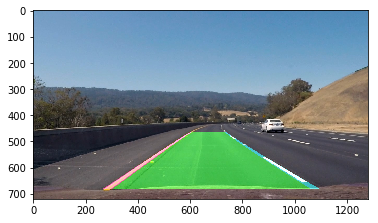

In [22]:
exampleImg_out1 = draw_lane(exampleImg,exampleImg_bin,left_fit,right_fit,Minv)
plt.imshow(exampleImg_out1)


In [24]:
# Draw curvature radius and distance from center 
def draw_data(original_img,curv_rad,center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + ' m'
    cv2.putText(new_img,text,(40,70),font,1.5,(200,255,155),2,cv2.LINE_AA)
    
    direction = ''
    
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    else:
        direction = 'Straight'
    abs_center_dist = abs(center_dist)
    text = '{:04.2f}'.format(abs_center_dist) + ' m ' + direction + ' of center'
    
    cv2.putText(new_img,text,(40,120),font,1.5,(200,255,155),2,cv2.LINE_AA)
    
    return new_img

print('Done!')


Done!


Done!


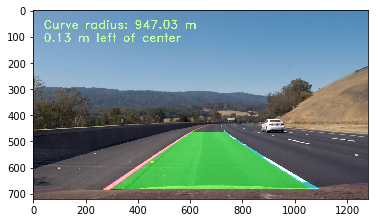

In [25]:
# Test in the image
exampleImg_out2 = draw_data(exampleImg_out1,(rad_l+rad_r)/2,d_center)
plt.imshow(exampleImg_out2)
print('Done!')

In [26]:
# Define a Line class for storing data
class Line():
    def __init__(self):
        # Was the line detected in the last iteration?
        self.detected = False
        
        # X value of the last n fits of the line
        self.recent_x_fitted = []
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        
        self.best_fit =None
        # Polynomial coefficients for the most recent fit 
        self.current_fit = []
        
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        # Difference in fir coefficients between last and new fits
        self.diffs = np.array([0,0,0],dtype='float')
        
        # number of detected pixels
        self.px_count = None
        
    def add_fit(self,fit,inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
                
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100) and len(self.current_fit) >0:
                self.detected = False
            
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                
                if len(self.current_fit) > 5:
                    # Eliminate the old ones
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit,axis=0)
            # Or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit)>0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit)>0:
                self.best_fit = np.average(self.current_fit,axis=0)
print('Done!')

Done!


### Define Complete image processing pipeline

Done!


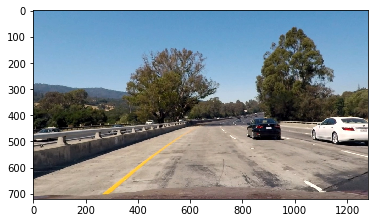

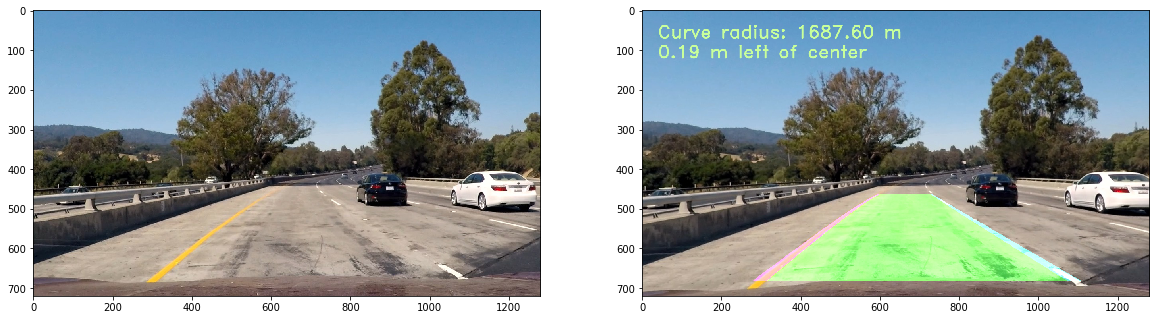

In [41]:
def process_image(img):
    
    new_img = undistort(np.copy(img))
    
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('Done!')

image = cv2.imread('./test_images/test1.jpg')
# Since the matplotlib show the image with RGB, conversely, cv2 is using the BGR color space
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(undistort(image))

image_pro = process_image(image)
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs = axs.ravel()

axs[0].imshow(image)
axs[1].imshow(image_pro)

In [42]:
# Method for plotting a fit on a binary image
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('Done!')


Done!


### Process project video

In [43]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:42<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 22s, sys: 1.78 s, total: 10min 24s
Wall time: 2min 43s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [45]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:02<00:00,  8.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 4min, sys: 1.08 s, total: 4min 1s
Wall time: 1min 3s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

In [47]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:03<00:00,  6.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 11min 6s, sys: 2.58 s, total: 11min 9s
Wall time: 3min 3s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output3))